In [28]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Define the cryptocurrency ticker
crypto_ticker = "ETH-USD"  
start_date = "2020-01-01"  
end_date = "2025-01-01"    

# Fetch historical data
data = yf.download(crypto_ticker, start=start_date, end=end_date, interval="1d")

print(data.head())

data.to_csv("crypto_data.csv")
print("Data saved to crypto_data.csv")

[*********************100%***********************]  1 of 1 completed


Price            Close        High         Low        Open       Volume
Ticker         ETH-USD     ETH-USD     ETH-USD     ETH-USD      ETH-USD
Date                                                                   
2020-01-01  130.802002  132.835358  129.198288  129.630661   7935230330
2020-01-02  127.410179  130.820038  126.954910  130.820038   8032709256
2020-01-03  134.171707  134.554016  126.490021  127.411263  10476845358
2020-01-04  135.069366  136.052719  133.040558  134.168518   7430904515
2020-01-05  136.276779  139.410202  135.045624  135.072098   7526675353
Data saved to crypto_data.csv


In [29]:

df = pd.read_csv('ETH-USD.csv')
# df.drop(index=[0,1], inplace=True)
df = df.iloc[2:]


In [30]:
df.head()

,Price,Close,High,Low,Open,Volume
2,2020-01-01,130.802001953125,132.83535766601562,129.1982879638672,129.6306610107422,7935230330
3,2020-01-02,127.4101791381836,130.82003784179688,126.95491027832031,130.82003784179688,8032709256
4,2020-01-03,134.1717071533203,134.55401611328125,126.49002075195312,127.41126251220703,10476845358
5,2020-01-04,135.06936645507812,136.05271911621094,133.04055786132812,134.16851806640625,7430904515
6,2020-01-05,136.2767791748047,139.4102020263672,135.04562377929688,135.0720977783203,7526675353


In [31]:
df.rename(columns={'Price': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.set_index('Date', inplace=True)

In [32]:
df.head()

,Close,High,Low,Open,Volume
Date,,,,,
2020-01-01,130.802001953125,132.83535766601562,129.1982879638672,129.6306610107422,7935230330
2020-01-02,127.4101791381836,130.82003784179688,126.95491027832031,130.82003784179688,8032709256
2020-01-03,134.1717071533203,134.55401611328125,126.49002075195312,127.41126251220703,10476845358
2020-01-04,135.06936645507812,136.05271911621094,133.04055786132812,134.16851806640625,7430904515
2020-01-05,136.2767791748047,139.4102020263672,135.04562377929688,135.0720977783203,7526675353


In [33]:
df[['Close','Open','Low','High','Volume']] = df[['Close','Open','Low','High','Volume']].astype('float')

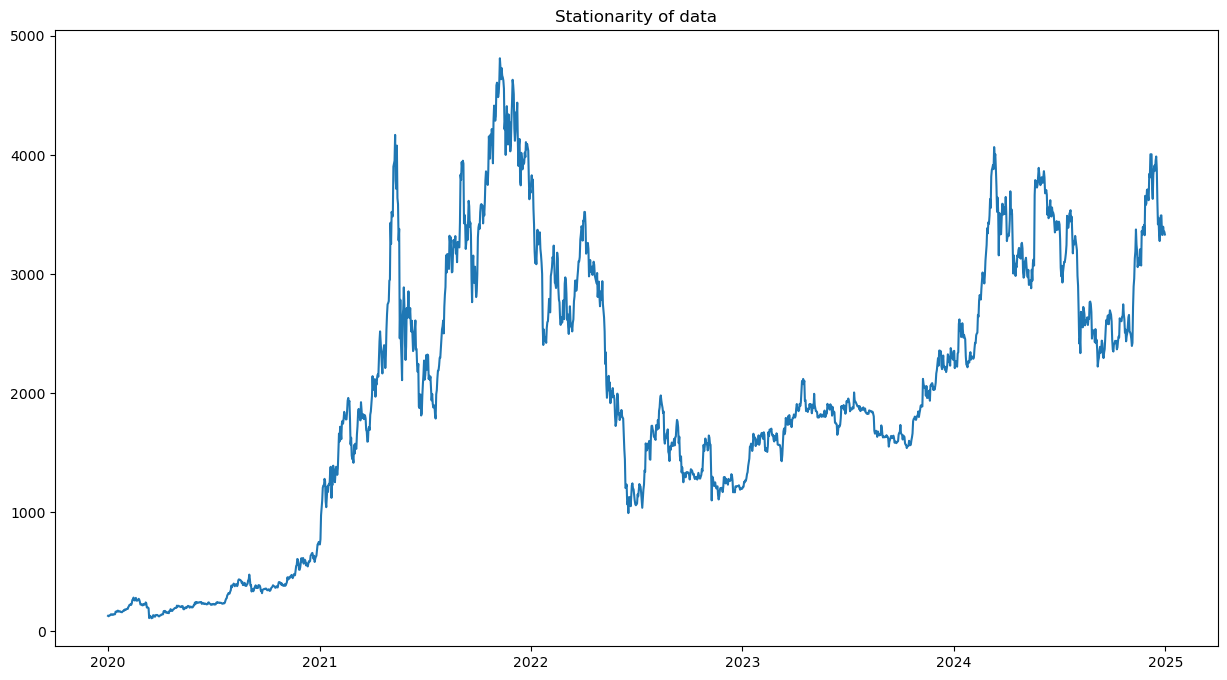

In [34]:
check = pd.DataFrame(df['Close'] )
plt.figure(figsize=(15,8))
plt.title('Stationarity of data')
plt.plot(check)

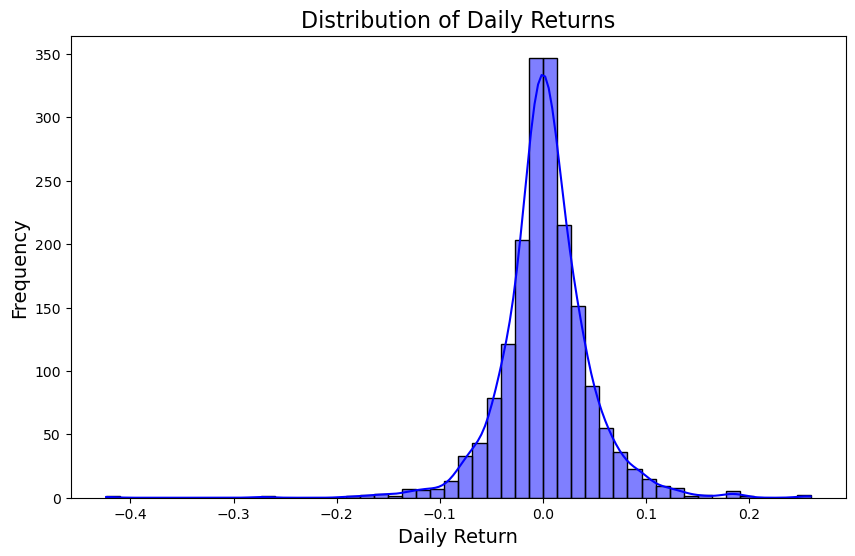

In [35]:
df['Daily Return'] = df['Close'].pct_change() #percentage change 

#analysing daily returns
plt.figure(figsize=(10, 6))
sns.histplot(df['Daily Return'].dropna(), kde=True, bins=50, color='blue')
plt.title('Distribution of Daily Returns', fontsize=16)
plt.xlabel('Daily Return', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

In [36]:
train = df.iloc[:-365]
test = df.iloc[-365:]

In [37]:
# Reverting back to make 'Date' a regular column
train.reset_index(inplace=True)
test.reset_index(inplace=True)

In [38]:
train = train.rename(columns={'Date': 'ds', 'Close': 'y'})
test = test.rename(columns={'Date': 'ds', 'Close': 'y'})

In [39]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

model = Prophet()
model.add_regressor('Volume')
model.add_regressor('Open')

In [40]:
def droping_cols(x):
    cols = ['High','Low','Daily Return','Rolling std','Rolling Std']
    for i in x.columns:
        if i in cols:
            x.drop(i, inplace=True,axis=1)

droping_cols(train)
droping_cols(test)
        

In [41]:
model.fit(train)

20:41:47 - cmdstanpy - INFO - Chain [1] start processing
20:41:48 - cmdstanpy - INFO - Chain [1] done processing


In [42]:
# Perform cross-validation
cv_results = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')
metrics = performance_metrics(cv_results)


  0%|          | 0/3 [00:00<?, ?it/s]

20:41:49 - cmdstanpy - INFO - Chain [1] start processing
20:41:49 - cmdstanpy - INFO - Chain [1] done processing
20:41:50 - cmdstanpy - INFO - Chain [1] start processing
20:41:50 - cmdstanpy - INFO - Chain [1] done processing
20:41:51 - cmdstanpy - INFO - Chain [1] start processing
20:41:51 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
forecast = model.predict(test)

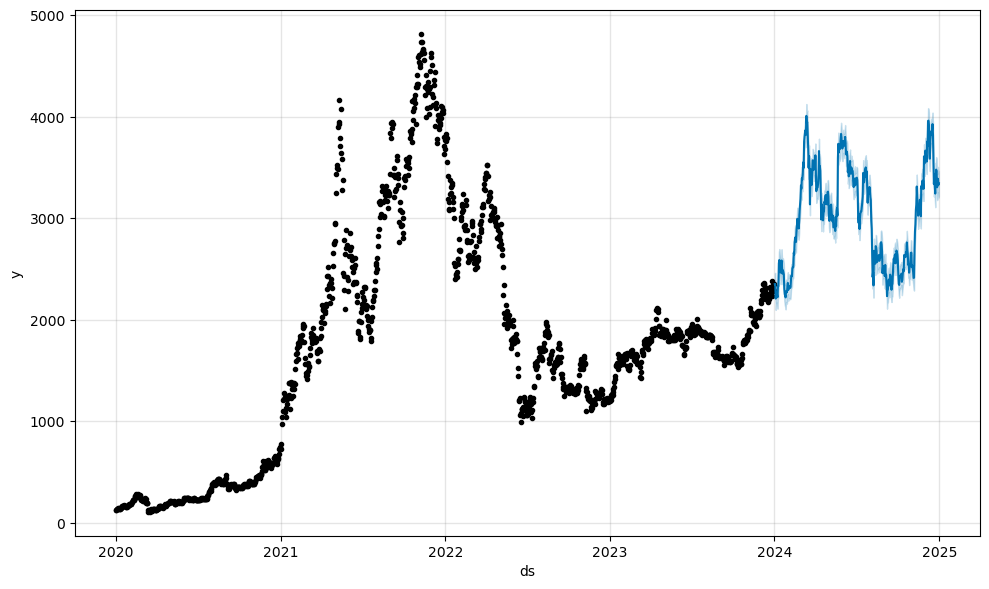

In [44]:
fig = model.plot(forecast)


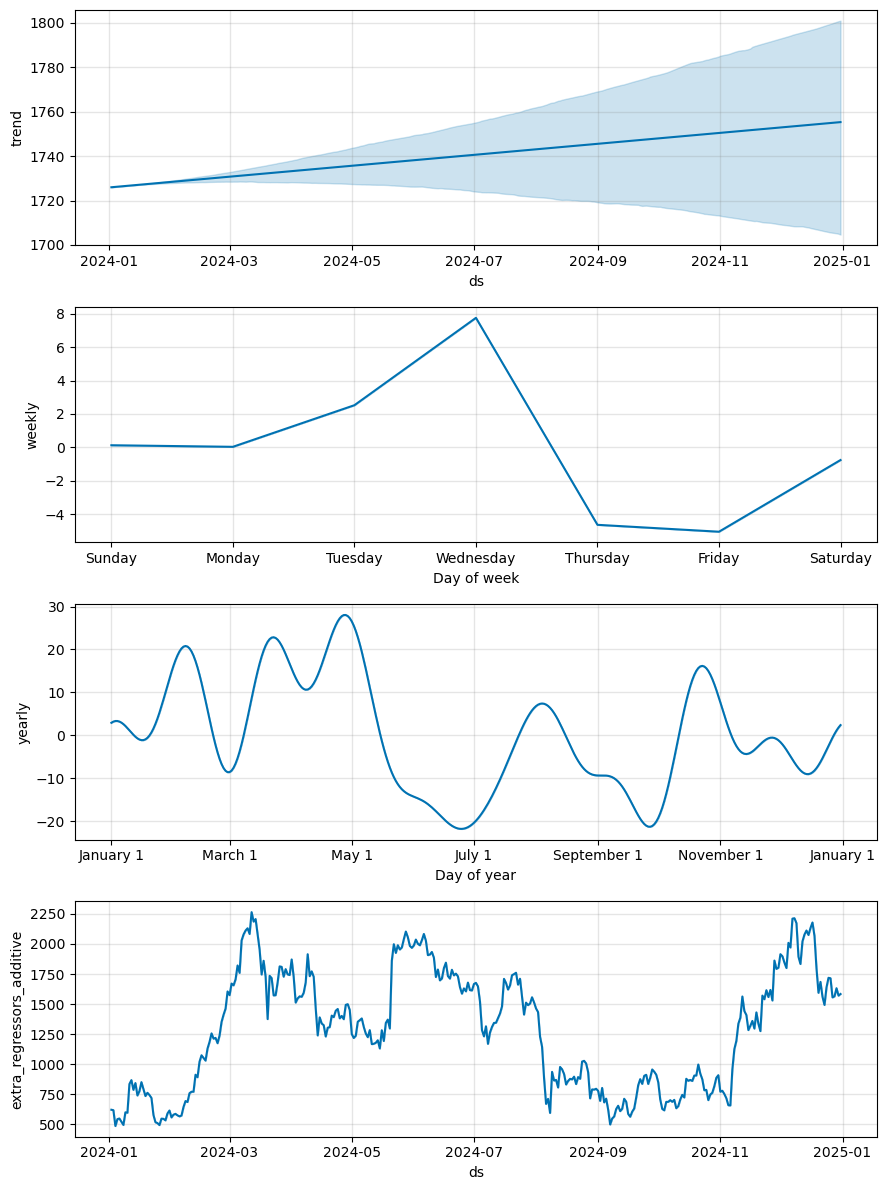

In [45]:
fig = model.plot_components(forecast)


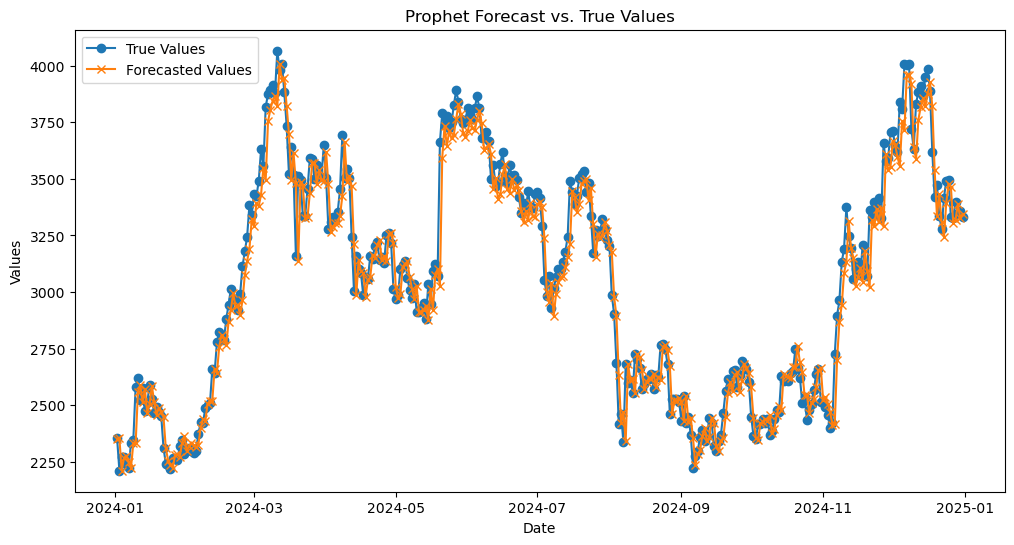

In [50]:
comparison = test[['ds', 'y']].merge(forecast[['ds', 'yhat']], on='ds')


plt.figure(figsize=(12, 6))
plt.plot(comparison['ds'], comparison['y'], label='True Values', marker='o')
plt.plot(comparison['ds'], comparison['yhat'], label='Forecasted Values', marker='x')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Prophet Forecast vs. True Values')
plt.legend()
plt.show()

In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Evaluate forecast vs. actual values
mse = mean_squared_error(test['y'], forecast['yhat'])
mae = mean_absolute_error(test['y'], forecast['yhat'])
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")


Mean Squared Error: 11726.592081431585
Mean Absolute Error: 77.04885741792745
Root Mean Squared Error: 108.28939043799068


In [49]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# Calculate MAPE
mape = mean_absolute_percentage_error(test['y'], forecast['yhat']) * 100

# Calculate R² score
r2 = r2_score(test['y'], forecast['yhat'])

print(f"Model Accuracy (1 - MAPE): {100 - mape:.2f}%")
print(f"R-squared Score: {r2:.4f}")

Model Accuracy (1 - MAPE): 97.50%
R-squared Score: 0.9547
